In [126]:
import globus_sdk
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D

In [127]:
""" Read Files into DataFrame objects """

data = pd.read_csv("test.csv") # reads comma delimited file into a DataFrame object
off_campus = pd.read_csv("offcampus_data.csv")
on_campus = pd.read_csv("oncampus_data.csv")
data.head(16) # returns the first n rows of the DataFrame, n here is 16

,Dataset,Start,End,Elapsed,Speed,Source EP ID,Dest. EP ID,Task ID
0,ds01,2020-12-15T03:16:17+00:00,2020-12-15T03:16:31+00:00,0:00:13.948828,6.83,606579ae-5b03-11e9-bf32-0edbf3a4e7ee,9c8c88c2-ea4a-11e6-b9ba-22000b9a448b,e4db46d6-3e83-11eb-b559-02d9497ca481
1,ds04,2020-12-15T03:16:31+00:00,2020-12-15T03:16:54+00:00,0:00:23.533417,411.39,606579ae-5b03-11e9-bf32-0edbf3a4e7ee,9c8c88c2-ea4a-11e6-b9ba-22000b9a448b,ed4bfb80-3e83-11eb-b559-02d9497ca481
2,ds06,2020-12-15T03:16:55+00:00,2020-12-15T03:20:09+00:00,0:03:13.832365,491.98,606579ae-5b03-11e9-bf32-0edbf3a4e7ee,9c8c88c2-ea4a-11e6-b9ba-22000b9a448b,fb776488-3e83-11eb-b559-02d9497ca481
3,ds08,2020-12-15T03:20:09+00:00,2020-12-15T03:46:26+00:00,0:26:17.256435,621.78,606579ae-5b03-11e9-bf32-0edbf3a4e7ee,9c8c88c2-ea4a-11e6-b9ba-22000b9a448b,6f31a0c8-3e84-11eb-b181-0ee0d5d9299f
4,ds10,2020-12-15T03:46:26+00:00,2020-12-15T04:10:47+00:00,0:24:20.822792,653.01,606579ae-5b03-11e9-bf32-0edbf3a4e7ee,9c8c88c2-ea4a-11e6-b9ba-22000b9a448b,1b813fca-3e88-11eb-b181-0ee0d5d9299f
5,ds12,2020-12-15T04:10:48+00:00,2020-12-15T04:15:05+00:00,0:04:17.624449,370.59,606579ae-5b03-11e9-bf32-0edbf3a4e7ee,9c8c88c2-ea4a-11e6-b9ba-22000b9a448b,8264d6a4-3e8b-11eb-b181-0ee0d5d9299f
6,ds14,2020-12-15T04:15:05+00:00,2020-12-15T06:16:39+00:00,2:01:33.838759,653.78,606579ae-5b03-11e9-bf32-0edbf3a4e7ee,9c8c88c2-ea4a-11e6-b9ba-22000b9a448b,1c2106b4-3e8c-11eb-b559-02d9497ca481
7,ds16,2020-12-15T06:16:40+00:00,2020-12-15T06:41:04+00:00,0:24:24.777208,651.11,606579ae-5b03-11e9-bf32-0edbf3a4e7ee,9c8c88c2-ea4a-11e6-b9ba-22000b9a448b,17bfb12c-3e9d-11eb-8fed-0a34088e79f9
8,ds01,2020-12-15T06:41:05+00:00,2020-12-15T06:42:00+00:00,0:00:55.646277,1.72,9c8c88c2-ea4a-11e6-b9ba-22000b9a448b,606579ae-5b03-11e9-bf32-0edbf3a4e7ee,80f7d874-3ea0-11eb-b55a-02d9497ca481
9,ds04,2020-12-15T06:42:01+00:00,2020-12-15T06:43:17+00:00,0:01:16.523024,124.72,9c8c88c2-ea4a-11e6-b9ba-22000b9a448b,606579ae-5b03-11e9-bf32-0edbf3a4e7ee,a24ffb50-3ea0-11eb-b181-0ee0d5d9299f


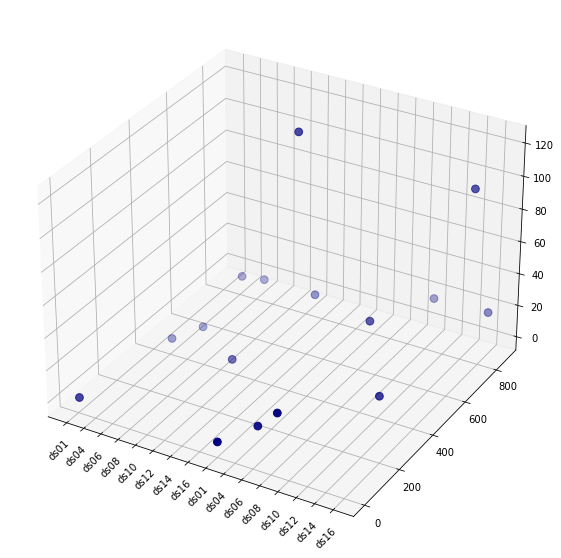

In [137]:
""" Builds a 3D plot based on the elapsed time values using pandas and matplotlib """

# plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(range(len(data['Dataset'])), data['Speed'],(pd.to_datetime(data['End'], infer_datetime_format=True) - pd.to_datetime(data['Start'], infer_datetime_format=True)).dt.total_seconds() / 60,  c='navy', s=60)
ax.set(xticks=range(len(data['Dataset'])), xticklabels=data['Dataset'])
plt.xticks(rotation=45)
plt.show()

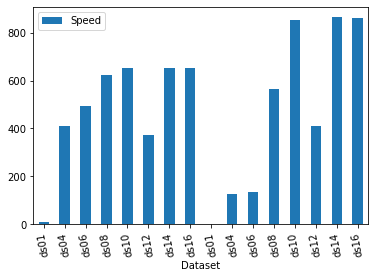

In [129]:
""" Builds bar graphs to represent data for different endpoints """

#plot
bg1 = data.plot.bar(x = 'Dataset', y = 'Speed', rot = 100) # graph shows the speed for each ds


In [1]:
""" Builds bar graphs to represent data for different endpoints """
"""
#time = (pd.to_datetime(data['End'], infer_datetime_format=True) - pd.to_datetime(data['Start']
bg2 = data.plot.bar(x = "Dataset",
                    y = (pd.to_datetime(data['End'], 
                    infer_datetime_format=True) - pd.to_datetime(data['Start'])),
                    rot=100)
"""

'\n#time = (pd.to_datetime(data[\'End\'], infer_datetime_format=True) - pd.to_datetime(data[\'Start\']\nbg2 = data.plot.bar(x = "Dataset",\n                    y = (pd.to_datetime(data[\'End\'], \n                    infer_datetime_format=True) - pd.to_datetime(data[\'Start\'])),\n                    rot=100)\n'

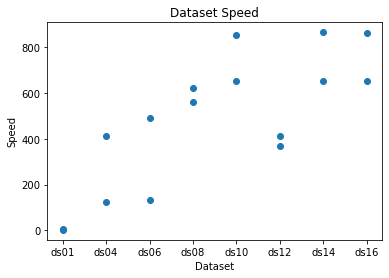

In [132]:
""" Builds scatter plots to represent data for different endpoints """

plt.scatter((data['Dataset']), data['Speed'])
plt.title('Dataset Speed')
plt.xlabel('Dataset')
plt.ylabel('Speed')
plt.show()